<a href="https://colab.research.google.com/github/ShaunakSen/Data-Science-and-Machine-Learning/blob/master/Clustering_UMAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Using UMAP for Clustering

[link](https://umap-learn.readthedocs.io/en/latest/clustering.html)

UMAP can be used as an effective preprocessing step to boost the performance of density based clustering. UMAP, like t-SNE, can also create tears in clusters that are not actually present, resulting in a finer clustering than is necessarily present in the data. Despite these concerns there are still valid reasons to use UMAP as a preprocessing step for clustering. As with any clustering approach one will want to do some exploration and evaluation of the clusters that come out to try to validate them if possible.

First we’ll need a selection of libraries loaded up. Obviously we’ll need data, and we can use sklearn’s fetch_mldata to get it. We’ll also need the usual tools of numpy, and plotting. Next we’ll need umap, and some clustering options. Finally, since we’ll be working with labeled data, we can make use of strong cluster evaluation metrics Adjusted Rand Index and Adjusted Mutual Information.

### Rand Index

[link](https://davetang.org/muse/2017/09/21/the-rand-index/)

![](https://s0.wp.com/latex.php?latex=R+%3D+%5Cfrac%7Ba+%2B+b%7D%7B+%7B%7Bn%7D%5Cchoose%7B2%7D%7D+%7D+&bg=ffffff&fg=000&s=0)

The a  in the formula refers to the number of times a pair of elements belongs to a same cluster across two different clustering results and the b  refers to the number of times a pair of elements are in different clusters across two different clustering results. 

Say we have a set of six elements: {a, b, c, d, e, f}. Clustering method 1 (CM1) forms three clusters; the first two items are in group 1, the third and fourth are in group 2, and the fifth and sixth are in group 3: {1, 1, 2, 2, 3, 3}. Clustering method 2 (CM2) forms two clusters; the first three items are in group 1 and the last three items are in group 2: {1, 1, 1, 2, 2, 2}. What’s the Rand index of these two clustering results?

To manually calculate the Rand index, we need to go through every unordered pair to work out a  and b ; let’s work out a  first. There are 15 unordered pairs in a set of six elements: {a, b}, {a, c}, {a, d}, {a, e}, {a, f}, {b, c}, {b, d}, {b, e}, {b, f}, {c, d}, {c, e}, {c, f}, {d, e}, {d, f}, and {e, f}. a  is every time a pair of elements is grouped together by the two clustering methods. {a, b} and {e, f} are clustered together by CM1 and CM2, so a  = 2. b  is every time a pair of elements is not grouped together by the two clustering methods. {a, d}, {a, e}, {a, f}, {b, d}, {b, e}, {b, f}, {c, e}, and {c, f} are not clustered together by CM1 and CM2, so b  = 8. a  and b  are the times that both clustering methods agree. Therefore, the Rand index is:


![](https://s0.wp.com/latex.php?latex=R+%3D+%5Cfrac%7B2+%2B+8%7D%7B+%7B%7B6%7D%5Cchoose%7B2%7D%7D%7D+%3D+%5Cfrac%7B10%7D%7B15%7D+%3D+0.667+&bg=ffffff&fg=000&s=0)

In [1]:
!pip install hdbscan

     |████████████████████████████████| 4.9MB 5.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.23-cp36-cp36m-linux_x86_64.whl size=2332155 sha256=18aaf6c6385d4a0c04fadd16056bffa3fe8872f0dc411e0807619fcd6449852e
  Stored in directory: /root/.cache/pip/wheels/1e/2a/69/0cdd5414624312666718f7526b0ab39cad65cea1c1b3892768
Successfully built hdbscan


In [0]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score



Now let’s set up the plotting and grab the data we’ll be using – in this case the MNIST handwritten digits dataset. MNIST consists of 28x28 pixel grayscale images of handwritten digits (0 through 9). These can be unraveled such that each digit is described by a 784 dimensional vector (the gray scale value of each pixel in the image). Ideally we would like the clustering to recover the digit structure.

In [3]:
sns.set(style='white', rc={'figure.figsize':(10,8)})
mnist = fetch_openml(name='mnist_784')

print (mnist.data.shape, mnist.target.shape)

(70000, 784) (70000,)


For visualization purposes we can reduce the data to 2-dimensions using UMAP. When we cluster the data in high dimensions we can visualize the result of that clustering. First, however, we’ll view the data a colored by the digit that each data point represents – we’ll use a different color for each digit. This will help frame what follows.



In [0]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(mnist.data)

In [5]:
standard_embedding.shape

(70000, 2)

In [6]:
standard_embedding[0]

array([ 0.5853949, -1.1981778], dtype=float32)

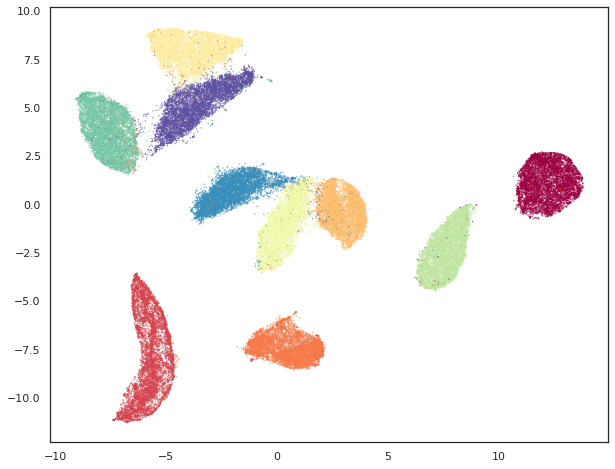

In [7]:
plt.scatter(x=standard_embedding[:,0], y=standard_embedding[:,1], c=mnist.target.astype('int'), s=0.1, cmap='Spectral');

### Traditional clustering

Now we would like to cluster the data. As a first attempt let’s try the traditional approach: K-Means. In this case we can solve one of the hard problems for K-Means clustering – choosing the right k value, giving the number of clusters we are looking for. In this case we know the answer is exactly 10. We will use sklearns K-Means implementation looking for 10 clusters in the original 784 dimensional data.



In [0]:
kmeans_labels = cluster.KMeans(n_clusters=10).fit_predict(mnist.data)

In [9]:
kmeans_labels

array([0, 1, 5, ..., 6, 0, 9], dtype=int32)

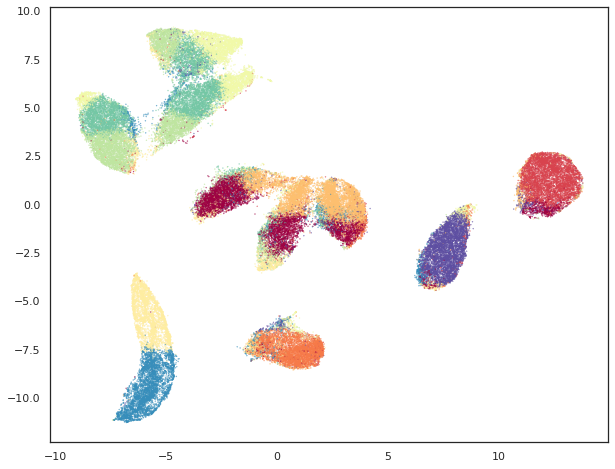

In [10]:
plt.scatter(x=standard_embedding[:,0], y=standard_embedding[:,1], c=kmeans_labels.astype('int'), s=0.1, cmap='Spectral');

This is not really the result we were looking for (though it does expose interesting properties of how K-Means chooses clusters in high dimensional space, and how UMAP unwraps manifolds by finding manifold boundaries. While K-Means gets some cases correct – the two clusters are the far right are mostly correct, most of the rest of the data looks somewhat arbitrarily carved up among the remaining clusters. We can put this impression to the test by evaluating the adjusted Rand score and adjusted mutual information for this clustering as compared with the true labels.

In [11]:
(
    adjusted_rand_score(labels_true=mnist.target, labels_pred=kmeans_labels),
    adjusted_mutual_info_score(labels_true=mnist.target, labels_pred=kmeans_labels)
)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


(0.36474869778057123, 0.4831503125962656)

As might be expected, we have not done a particularly good job – both scores take values in the range 0 to 1, with 0 representing a bad (essentially random) clustering and 1 representing perfectly recovering the true labels. K-Means definitely was not random, but it was also quite a long way from perfectly recovering the true labels. Part of the problem is the way K-Means works, based on centroids with an assumption of largely spherical clusters – this is responsible for some of the sharp divides that K-Means puts across digit classes. We can potentially improve on this by using a smarter density based algorithm. In this case we’ve chosen to try HDBSCAN, which we believe to be among the most advanced density based tehcniques. For the sake of performance we’ll reduce the dimensionality of the data down to 50 dimensions via PCA (this recovers most of the variance), since HDBSCAN scales somewhat poorly with the dimensionality of the data it will work on.

In [0]:
lowd_mnist = PCA(n_components=50).fit_transform(mnist.data)

Now we again run UMAP to verify whether the spatial relationship is preserved in this new lower dimensional space


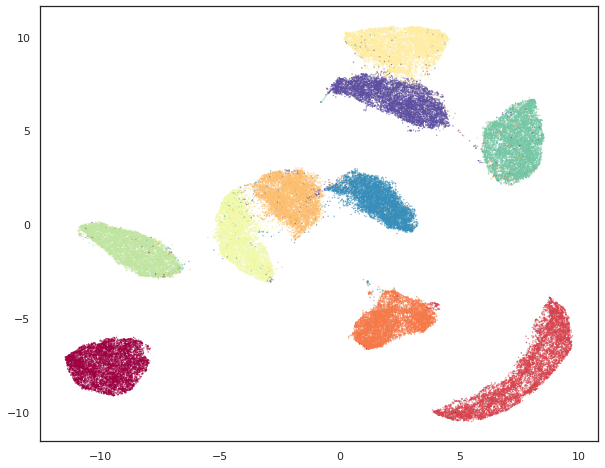

In [13]:
standard_embedding_lowd = umap.UMAP(random_state=42).fit_transform(lowd_mnist.data)

plt.scatter(x=standard_embedding_lowd[:,0], y=standard_embedding_lowd[:,1], c=mnist.target.astype('int'), s=0.1, cmap='Spectral');

It is clear that even after reducing to 50 dimensions the clusters are well separated. 

In [27]:
print (lowd_mnist.shape)

(70000, 50)


In [0]:
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(lowd_mnist)

In [15]:
hdbscan_labels.shape

(70000,)

We can now inspect the results. Before we do, however, it should be noted that one of the features of HDBSCAN is that it can refuse to cluster some points and classify the as “noise”. To visualize this aspect we will colorpoints that were classified as noise gray, and then color the remaining points according to the cluster membership.



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


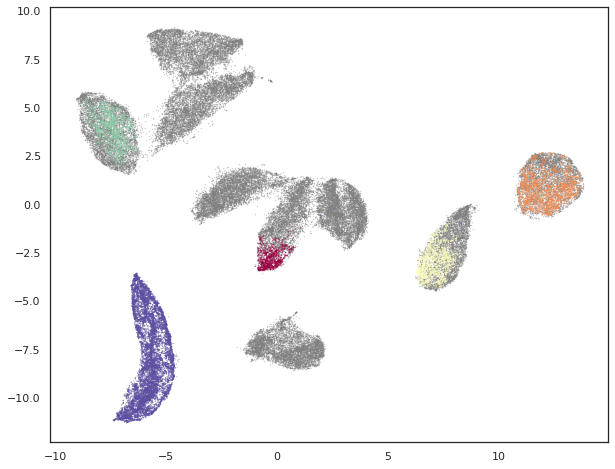

In [16]:
clustered = (hdbscan_labels >= 0)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=hdbscan_labels[clustered],
            s=0.1,
            cmap='Spectral');

In [17]:
(
    adjusted_rand_score(labels_true=mnist.target, labels_pred=hdbscan_labels),
    adjusted_mutual_info_score(labels_true=mnist.target, labels_pred=hdbscan_labels)
)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


(0.05289726927411719, 0.19403344656606747)

These scores are far worse than K-Means! Partially this is due to the fact that these scores assume that the noise points are simply an extra cluster. We can instead only look at the subset of the data that HDBSCAN was actually confident enough to assign to clusters – a simple sub-selection will let us recompute the scores for only that data.



In [18]:
clustered = (hdbscan_labels >= 0)
(
    adjusted_rand_score(mnist.target[clustered], hdbscan_labels[clustered]),
    adjusted_mutual_info_score(mnist.target[clustered], hdbscan_labels[clustered])
)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


(0.9984718644811594, 0.9944588261311276)

And here we see that where HDBSCAN was willing to cluster it got things almost entirely correct. This is what it was designed to do – be right for what it can, and defer on anything that it couldn’t have sufficient confidence in. Of course the catch here is that it deferred clustering a lot of the data. How much of the data did HDBSCAN actually assign to clusters? We can compute that easily enough.



In [19]:
np.sum(clustered) / mnist.data.shape[0]

0.1674142857142857

It seems that less than 18% of the data was clustered. While HDBSCAN did a great job on the data it could cluster it did a poor job of actually managing to cluster the data. The problem here is that, as a density based clustering algorithm, HDBSCAN tends to suffer from the curse of dimensionality: high dimensional data requires more observed samples to produce much density. If we could reduce the dimensionality of the data more we would make the density more evident and make it far easier for HDBSCAN to cluster the data. The problem is that trying to use PCA to do this is going to become problematic. While reducing the 50 dimensions still explained a lot of the variance of the data, reducing further is going to quickly do a lot worse. This is due to the linear nature of PCA. What we need is strong manifold learning, and this is where UMAP can come into play.

### UMAP enhanced clustering

Our goal is to make use of UMAP to perform non-linear manifold aware dimension reduction so we can get the dataset down to a number of dimensions small enough for a density based clustering algorithm to make progress. One advantage of UMAP for this is that it doesn’t require you to reduce to only two dimensions – you can reduce to 10 dimensions instead since the goal is to cluster, not visualize, and the performance cost with UMAP is minimal. **As it happens MNIST is such a simple dataset that we really can push it all the way down to only two dimensions, but in general you should explore different embedding dimension options.**



The next thing to be aware of is that when using UMAP for dimension reduction you will want to select different parameters than if you were using it for visualization. First of all we will want a larger n_neighbors value – small values will focus more on very local structure and are more prone to producing fine grained cluster structure that may be more a result of patterns of noise in the data than actual clusters. In this case we’ll double it from the default 15 up to 30. Second it is beneficial to set min_dist to a very low value. Since we actually want to pack points together densely (density is what we want after all) a low value will help, as well as making cleaner separations between clusters. In this case we will simply set min_dist to be 0.

In [0]:
clusterable_embeddings = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=42).fit_transform(mnist.data)

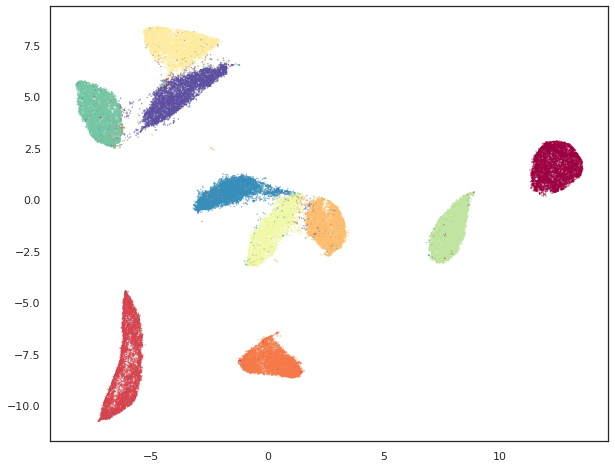

In [22]:
plt.scatter(x=clusterable_embeddings[:,0], y=clusterable_embeddings[:,1], c=mnist.target.astype('int'), s=0.1, cmap='Spectral');

As you can see we still have the general global structure, but we are packing points together more tightly within clusters, and consequently we can see larger gaps between the clusters. Ultimately this embedding was for clustering purposes only, and we will go back to the original embedding for visualization purposes from here on out.

The next step is to cluster this data. We’ll use HDBSCAN again, with the same parameter setting as before.

In [26]:
print (clusterable_embeddings.shape)

(70000, 2)


`clusterable_embeddings` is now in a 2D space. Previously `lowd_mnsist` was in a 50D space

In [0]:
labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(clusterable_embeddings)

In [28]:
print (labels.shape)

(70000,)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(70000,)


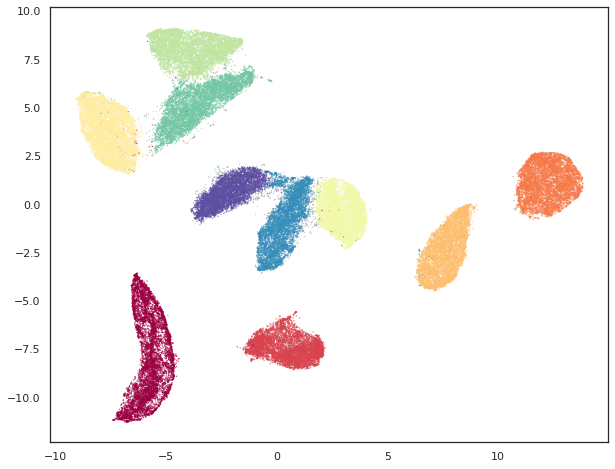

In [29]:
clustered = (labels >= 0)
print (clustered.shape)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral');

We can see that we have done a much better job of finding clusters rather than merely assigning the majority of data as noise. **This is because we have we no longer have to try to cope with the relative lack of density in 50 dimensional space and now HDBSCAN can more cleanly discern the clusters.**

